# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [13]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torchvision import  models

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
## YOUR CODE HERE ##
#Normalization mean and standard deviation Resnet
mean= [0.485,0.456,0.406]
std= [0.229,0.224,0.225]

#batch_size
batchsize = 16
train_transform = transforms.Compose([transforms.RandomRotation(30),transforms.Resize(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

test_transform=transforms.Compose([transforms.Resize(224),transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_dataset = torchvision.datasets.CIFAR10(root='./data',download=True,transform=train_transform)



# Create test set and define test dataloader
## YOUR CODE HERE ##
test_dataset = torchvision.datasets.CIFAR10(root='./data',download=True,transform=test_transform)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
!pip install split_folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
def get_subset(indices, start, end):
    return indices[start : start + end]


#TRAIN_PCT, VALIDATION_PCT = 0.6, 0.2  # rest will go for test
train_count = int(len(train_dataset) * 0.6)
validation_count = int(len(train_dataset) * 0.2)
print(f'train size: {train_count}' )
print(f'validation size:{validation_count} ' )


indices = torch.randperm(len(train_dataset))

train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(train_dataset))
print(f'test size: {len(test_indices)}')

train size: 30000
validation size:10000 
test size: 10000


In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

train = torch.utils.data.DataLoader(train_dataset, sampler=SubsetRandomSampler(train_indices),batch_size=batchsize)
validation = torch.utils.data.DataLoader(train_dataset, sampler=SubsetRandomSampler(validation_indices),batch_size=batchsize)
test = torch.utils.data.DataLoader(test_dataset, sampler=SubsetRandomSampler(test_indices),batch_size=batchsize)
print(f'train dataset size: {len(train)}' )
print(f'validation dataset size:{len(validation)} ' )
print(f'test dataset size: {len(test)}')
   

train dataset size: 1875
validation dataset size:625 
test dataset size: 625


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

**Note** In order to explore my data I had to create a new dataset, Since my training data_loader has been transformed 
with data augumentation techniques the result from exploring the data would not appear as i want.
Although the test loader works well because it was not augumented. Additionally a normalization function was added to set
the Image in the desired range (0,1)

img_dataset = torchvision.datasets.CIFAR10(root='./data',download=True,train=True,transform = test_transform)
img_loader = torch.utils.data.DataLoader(img_dataset,batch_size= batchsize,shuffle=True)

In [7]:
def save_checkpoint(state,filename =r'C:\Users\IT\Desktop\Udacity\Deeplearning\my_checkpoint.pth'):
    print('saving checkpoint')
    torch.save(state,filename)

In [8]:
def load_checkpoint(model):
    print('load model')
    model.load_state_dict(checkpoint['state_dic'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [9]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        image = NormalizeData(image)
        #print(np.min(image))
        #print(np.max(image))
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Files already downloaded and verified
car


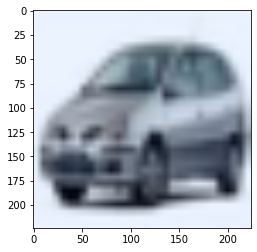

deer


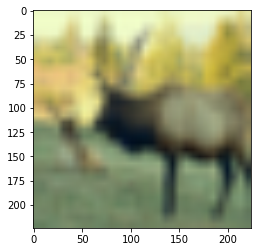

plane


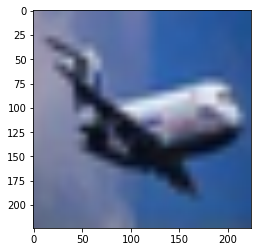

ship


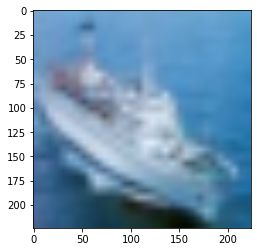

car


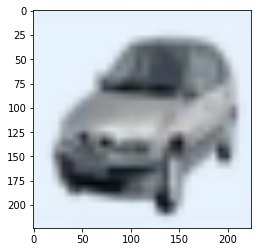

In [11]:
# Explore data
img_dataset = torchvision.datasets.CIFAR10(root='./data',download=True,train=True,transform=test_transform)
img_loader = torch.utils.data.DataLoader(img_dataset,batch_size= batchsize,shuffle=True)

## YOUR CODE HERE ##
show5(img_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [14]:
## YOUR CODE HERE ##
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad= False
        

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
## YOUR CODE HERE ##
model.fc =nn.Linear(512,10)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:
load_checkpoint(model)

load model


In [26]:
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
## YOUR CODE HERE ##
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
steps = 0
load_model = False
if load_model:
    load_checkpoint(torch.load(r'C:\Users\IT\Desktop\Udacity\Deeplearning\my_checkpoint.pth'))
        
train_losses, val_losses = [], []
for e in range(epochs):
    
    if e % 2 == 0:
        checkpoint = {'state_dic':model.state_dict(),'optimizer':optimizer.state_dict()}
        save_checkpoint(checkpoint,filename=r'C:\Users\IT\Desktop\Udacity\Deeplearning\my_checkpoint.pth')
    running_loss = 0
    trainacc=0
    for images, labels in train:
        images= images.to('cuda')
        labels= labels.to('cuda')
        
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        val_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in validation:
                images=images.to('cuda')
                labels= labels.to('cuda')
                log_ps = model.forward(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train))
        val_losses.append(val_loss/len(validation))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train)),
              "Test Loss: {:.3f}.. ".format(val_loss/len(validation)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validation)))

saving checkpoint
Epoch: 1/10..  Training Loss: 1.265..  Test Loss: 1.250..  Test Accuracy: 0.563
Epoch: 2/10..  Training Loss: 1.240..  Test Loss: 1.222..  Test Accuracy: 0.578
saving checkpoint
Epoch: 3/10..  Training Loss: 1.222..  Test Loss: 1.231..  Test Accuracy: 0.562
Epoch: 4/10..  Training Loss: 1.207..  Test Loss: 1.213..  Test Accuracy: 0.579
saving checkpoint
Epoch: 5/10..  Training Loss: 1.202..  Test Loss: 1.200..  Test Accuracy: 0.582
Epoch: 6/10..  Training Loss: 1.191..  Test Loss: 1.187..  Test Accuracy: 0.580
saving checkpoint
Epoch: 7/10..  Training Loss: 1.182..  Test Loss: 1.188..  Test Accuracy: 0.582
Epoch: 8/10..  Training Loss: 1.178..  Test Loss: 1.175..  Test Accuracy: 0.584
saving checkpoint
Epoch: 9/10..  Training Loss: 1.170..  Test Loss: 1.162..  Test Accuracy: 0.590
Epoch: 10/10..  Training Loss: 1.167..  Test Loss: 1.170..  Test Accuracy: 0.590


Plot the training loss (and validation loss/accuracy, if recorded).

In [28]:
val_l =  [l.to('cpu') for l in val_losses]

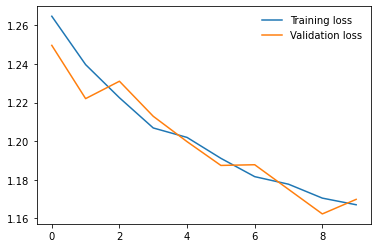

In [29]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(val_l, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [30]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
len(test)

625

In [32]:
model.eval()
with torch.no_grad():
    for images, labels in test:
        images.to('cpu')
        labels = labels.to('cpu')
        predictions = model(images)
        rounded_preds = torch.round(predictions)                         
        correct = (rounded_preds.argmax(1) == labels).float() 
        acc = correct.sum() / len(correct)

    print(f"Test Accuracy of the model: {acc*100:.2f}")

Test Accuracy of the model: 68.75


## Saving your model
Using `torch.save`, save your model for future loading.

In [33]:
checkpoint = {'state_dic':model.state_dict(),'optimizer':optimizer.state_dict()}
save_checkpoint(checkpoint,filename=r'C:\Users\IT\Desktop\Udacity\Deeplearning\my_checkpoint.pth')

saving checkpoint


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

- The model accuracy is slightly lower than Detectocorp's model and algorithm hence significant optimization,computation and tuning would have to be carried out to improve the model.In this case the training has to be done on more epochs 

- The accuracy of my model is less than those of the advanced solutions described in the literature

- I used a Resnet18 pretrained network using a total of 15 epochs, cross entropy loss and adam optimizer

- It is possible to improve my accuracy,it would be required to train over more epochs and add an early stopping parameter to avoid overfitting. Since an accuracy of 68.75% could be achieved using a resnet18 model over 15 epochs,i recommend we should create an in house model.

